# This notebook runs a covariance based Monte Carlo propagation in ADAM

In [1]:
from adam import PropagationParams
from adam import OpmParams
from adam import ConfigManager
from adam import ProjectsClient
from adam import AdamProcessingService
from adam import MonteCarloResults
from adam import OrbitEventType
import matplotlib.pyplot as plt

This sets up authenticated access to the server. It needs to be done before pretty much everything you want to do with ADAM.

In [2]:
# ConfigManager loads the config set up via adamctl.
# See the README at https://github.com/B612-Asteroid-Institute/adam_home/blob/master/README.md
config = ConfigManager().get_config('dev')
project = ProjectsClient().get_project_from_config(config)
aps = AdamProcessingService()

## Example Inputs

The PropagationParameters sent to the propagation API will operate on either Keplerian or Cartesian elements.

In [3]:
# from https://newton.spacedys.com/neodys/index.php?pc=1.1.1.1&n=2000SG344
# true_anomaly_deg is also available instead of mean_anomaly_deg
keplerian_elements = {
    'semi_major_axis_km': 146222900,
    'eccentricity': 0.066958,
    'inclination_deg': 0.112,
    'ra_of_asc_node_deg' : 191.912,
    'arg_of_pericenter_deg' :  275.347,
    'mean_anomaly_deg' : 35.681,
    'gm' : 132712440041.93938 #JPL Horizons GM
}

# Lower triangular covariance matrix (21 elements in a list)
covariance = [3.94346903514E+03, + \
             -1.40266786788E-04, 5.00812620000E-12, + \
             -2.91357694324E-04, 1.06017205000E-11, 3.15658331000E-11, + \
             -3.83826656095E-03, 1.40431472000E-10, 2.32155752000E-09, 8.81161492000E-07, + \
             -1.09220523817E-02, 3.62452521000E-10, -1.53067748000E-09, -8.70304198000E-07, 9.42413982000E-07, + \
             -2.96713683611E-01, 1.05830167000E-08, 2.23110293000E-08, 2.93564832000E-07, 7.81029359000E-07, 2.23721205000E-05]

### Set Parameters

Commented parameters are optional. Uncomment to use.

In [4]:
propagation_params = PropagationParams({
    'start_time': '2017-10-04T00:00:00Z',   # propagation start time in ISO format
    'end_time': '2017-10-11T00:00:00Z',     # propagation end time in ISO format

    'project_uuid': config['workspace'],
    'description': 'Jupyter Keplerian Covariance Monte Carlo Example',
    'monteCarloDraws': 10,
    'propagationType': 'MONTE_CARLO',
    'stopOnImpact': True,
    'step_size': 86400,
    'stopOnCloseApproach': False,
    'stopOnImpactAltitudeMeters': 500000,
    'closeApproachRadiusFromTargetMeters': 7000000000
})

opm_params = OpmParams({
    'epoch': '2017-10-04T00:00:00Z',
    'keplerian_elements': keplerian_elements,
    'keplerian_covariance': covariance,   # object covariance
            
#     'mass': 500.5,              # object mass
#     'solar_rad_area': 25.2,     # object solar radiation area (m^2)
#     'solar_rad_coeff': 1.2,     # object solar radiation coefficient
#     'drag_area': 33.3,          # object drag area (m^2)
#     'drag_coeff': 2.5,          # object drag coefficient
    
})

### Submit and Run Propagation

In [ ]:
batch_run = aps.execute_batch_propagation(
    project, 
    propagation_params, 
    opm_params, 
    object_id="KeplerianCovarianceObject01",
    user_defined_id="KeplerianCovarianceWorkbook"
)

### Get Status

In [6]:
# See example notebook on how to search the ADAM system for previous submitted jobs
print(batch_run.check_status())
batch_run.wait_for_complete(max_wait_sec=500, print_waiting = True)
print()
print(batch_run.check_status())

CREATED
CREATED
.............RUNNING
.....
COMPLETED


### Get Summary Statistics

In [7]:
stats = batch_run.get_summary()
print(stats)
print(stats.get_misses())

MonteCarloSummary(misses=11, close_approaches=0, impacts=0, pc=0.0)
11


### Get Ephemeris for specific run

       Epoch             X             Y             Z         Vx         Vy  \
0 2017-10-04 -1.171214e+08  6.777029e+07 -2.958767e+07 -18.050466 -23.957754   
1 2017-10-05 -1.186591e+08  6.568785e+07 -2.868076e+07 -17.542400 -24.245335   
2 2017-10-06 -1.201526e+08  6.358098e+07 -2.776319e+07 -17.029093 -24.523191   
3 2017-10-07 -1.216015e+08  6.145052e+07 -2.683531e+07 -16.510792 -24.791251   
4 2017-10-08 -1.230055e+08  5.929733e+07 -2.589751e+07 -15.987743 -25.049451   
5 2017-10-09 -1.243641e+08  5.712226e+07 -2.495015e+07 -15.460195 -25.297733   
6 2017-10-10 -1.256769e+08  5.492617e+07 -2.399361e+07 -14.928395 -25.536046   
7 2017-10-11 -1.269436e+08  5.270992e+07 -2.302827e+07 -14.392592 -25.764343   

          Vz  
0  10.433493  
1  10.559056  
2  10.680384  
3  10.797444  
4  10.910210  
5  11.018655  
6  11.122758  
7  11.222497  


<AxesSubplot:xlabel='Epoch'>

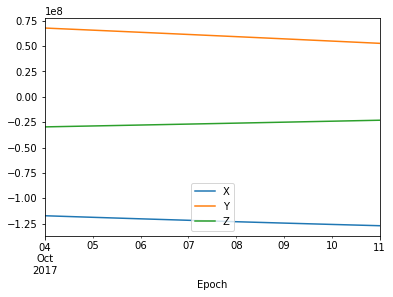

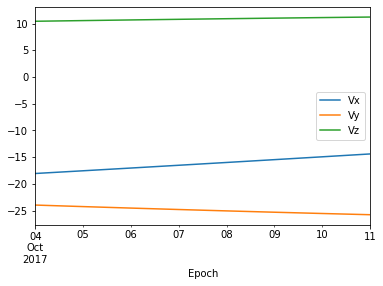

In [8]:
eph = batch_run.get_ephemeris_as_dataframe(2)
print(eph)
eph.plot(x='Epoch', y=['X','Y','Z'])
eph.plot(x='Epoch', y=['Vx','Vy','Vz'])

In [9]:
ephem_raw_data = batch_run.get_ephemeris_content(2)
print(ephem_raw_data)

stk.v.11.0
BEGIN Ephemeris
ScenarioEpoch 04 Oct 2017 00:00:00.000000
CentralBody SUN
CoordinateSystem ICRF
InterpolationMethod HERMITE
InterpolationOrder 5
NumberOfEphemerisPoints 8

EphemerisTimePosVel
0.000000000000e+00 -1.171214013517e+11 7.394732652019e+10 -1.886822514175e+08 -1.805046562904e+04 -2.613101426534e+04 4.269553588623e+01
8.640000000000e+04 -1.186590517895e+11 7.167597477504e+10 -1.849582777052e+08 -1.754240031026e+04 -2.644481117664e+04 4.350457805057e+01
1.728000000000e+05 -1.201525771618e+11 6.937796866428e+10 -1.811651791299e+08 -1.702909322465e+04 -2.674800013735e+04 4.429560675089e+01
2.592000000000e+05 -1.216015352532e+11 6.705422807413e+10 -1.773045226884e+08 -1.651079151974e+04 -2.704050449973e+04 4.506837787666e+01
3.456000000000e+05 -1.230055052211e+11 6.470567922514e+10 -1.733778959434e+08 -1.598774276089e+04 -2.732225427651e+04 4.582265944850e+01
4.320000000000e+05 -1.243640876231e+11 6.233325409870e+10 -1.693869059833e+08 -1.546019472373e+04 -2.75931860932

### Get ending state vector

In [10]:
close_approach_states = batch_run.get_states_dataframe(OrbitEventType.CLOSE_APPROACH)
print("\nClose State Vectors")
if not close_approach_states.empty:
    print(f'First close approach state:\n{close_approach_states.loc[0]}')
else:
    print("None")


impact_states = batch_run.get_states_dataframe(OrbitEventType.IMPACT)
print("\nImpact State Vectors")
if not impact_states.empty:
    print(f'First impact end state:\n{impact_states.loc[0]}')
else:
    print("None")


miss_states = batch_run.get_states_dataframe(OrbitEventType.MISS)
print("\nMiss State Vectors")
if not miss_states.empty:
    print(f'First miss end state:\n{miss_states.loc[0]}')
else:
    print("None")



Close State Vectors
None

Impact State Vectors
None

Miss State Vectors
First miss end state:
epoch    2017-10-11T00:00:00Z
x        -269283286686.194489
y           16022240493.69976
z         -18148301392.883297
xdot            -14391.486058
ydot            -28102.904726
zdot                47.975807
Name: 0, dtype: object
